<a href="https://colab.research.google.com/github/rdzhulai/Battery_RUL_prediction/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
%pip install -q PyAV torchmetrics

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms.v2 as T
from torchvision.io import read_image, ImageReadMode
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision.models.optical_flow import raft_large, Raft_Large_Weights, Raft_Small_Weights, raft_small
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torchmetrics

print(torch.__version__, torchvision.__version__)

2.2.1+cu121 0.17.1+cu121


In [51]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [52]:
BATCH_SIZE = 1
EPOCHS = 1

FRAME_WIDTH = 288
FRAME_HEIGHT = 296

MAX_SEQ_LENGTH = 5
TEMPORAL_STEP = 10

DATA_DIR_PATH = "/content/drive/MyDrive/sliding-classifier/train_data"
SLIDING_METAFILE_PATH = "/content/drive/MyDrive/sliding-classifier/sliding_metafile.csv"

In [53]:
df = pd.read_csv(SLIDING_METAFILE_PATH)
print(f"{len(df[df['video_class'] == 'ls_p'])} vs {len(df[df['video_class'] == 'ls_a'])}")

139 vs 32


In [54]:
# Split data into train and test sets (e.g., 80%/20%)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Further split the train set into train and validation sets (e.g., 60%/20%)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)


print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")
print(f"Total videos for validation: {len(test_df)}")

train_df.head()

Total videos for training: 102
Total videos for testing: 35
Total videos for validation: 35


,video_name,video_class
100,Sonoscape_2021-09_2021-10-18_002_20211008_1108...,ls_a
134,003_image_70959392795.mp4,ls_p
63,Old_dataset_LSP_2.avi,ls_p
27,Sonoscape_2021-09_2021-10-18_002_20210930_1547...,ls_p
115,Old_dataset_LSP_17.avi,ls_p


In [55]:
# train_df = train_df.sample(20, random_state=42)
# test_df = test_df.sample(5, random_state=42)
# val_df = val_df.sample(5, random_state=42)

In [56]:
# import os

# def video_exists(video_name, folder_path):
#   """
#   Checks if a video exists in the specified folder.
#   """
#   file_path = os.path.join(folder_path, video_name)
#   return os.path.isfile(file_path)

# def filter_dataframe(df, folder_path):
#   """
#   Filters the DataFrame to keep rows where videos exist in the folder.
#   """
#   return df[df["video_name"].apply(lambda name: video_exists(name, folder_path))]

# # Filter the DataFrame
# train_df = filter_dataframe(train_df, DATA_DIR_PATH)  # Copy to avoid modifying original DataFrame
# test_df = filter_dataframe(test_df, DATA_DIR_PATH)

# print(f"Total videos for training: {len(train_df)}")
# print(f"Total videos for testing: {len(test_df)}")

# train_df.sample(10)

In [57]:
class VocabularyMapping:
    def __init__(self, labels):
        self.mapping = {label: index for index, label in enumerate(labels)}

    def __call__(self, labels):
        return torch.tensor([self.mapping[label] for label in labels], dtype=torch.float32)

label_processor = VocabularyMapping(np.unique(train_df["video_class"]))
print(list(label_processor.mapping.keys()))

['ls_a', 'ls_p']


In [58]:
class OpticalFlowExtractor:
  def __init__(self):
    weights = Raft_Small_Weights.DEFAULT
    self.model = raft_small(weights=weights, progress=False).to(device)
    self.model = self.model.eval()
    self.transforms = weights.transforms()

  def _preprocess(self, frame1_batch, frame2_batch):
    frame1_batch = T.functional.resize(frame1_batch, size=[FRAME_HEIGHT, FRAME_WIDTH], antialias=False)
    frame2_batch = T.functional.resize(frame2_batch, size=[FRAME_HEIGHT, FRAME_WIDTH], antialias=False)
    return self.transforms(frame1_batch, frame2_batch)

  def __call__(self, frame1_batch, frame2_batch):
    frame1_batch, frame2_batch = self._preprocess(frame1_batch, frame2_batch)
    return self.model(frame1_batch, frame2_batch)

optical_flow_extractor = OpticalFlowExtractor()

In [59]:
# class FeatureExtractor:
#     def __init__(self):
#         weights = Inception_V3_Weights.DEFAULT
#         self.model = inception_v3(weights=weights)
#         self.model = self.model.eval()
#         self.transforms = weights.transforms()

#     def preprocess(self, img_batch):
#         return self.transforms(img_batch)

#     def extract(self, batch):
#         return  self.model(batch)

# feature_extractor = FeatureExtractor()

In [60]:
# from torchvision.utils import flow_to_image

# flow_frames = flow_to_image(flows)
# # Assuming your image data is in two lists: list1 (5 elements) and list2 (5 elements)
# fig, axes = plt.subplots(5, 2, figsize=(8, 12))  # Adjust figsize for desired size

# # Flatten the lists into a single iterator
# frame1_batch = [(frame1 + 1) / 2 for frame1 in frame1_batch]

# grid = [[frame1.permute(1, 2, 0), flow_frame.permute(1, 2, 0)] for (frame1, flow_frame) in zip(frame1_batch, flow_frames)]
# # Enumerate the iterator to get index and image data
# for i, (img1, img2) in enumerate(grid):
#   # Access subplots based on index (avoiding nested loops)
#   #ax1, ax2 = axes[i, 0], axes[i, 1]  # Integer division and modulo for grid position

#   axes[i, 0].imshow(img1)
#   axes[i, 1].imshow(img2)


# plt.tight_layout()
# plt.show()

In [61]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(FRAME_HEIGHT, FRAME_WIDTH))
])

In [62]:
# video_path = os.path.join(DATA_DIR_PATH, train_df["video_name"].iloc[4])
# frame_names = os.listdir(video_path)
# frame_names.sort(key=lambda x: int(x[6:-4]))
# frame = read_image(os.path.join(video_path, frame_names[0]), ImageReadMode.RGB).to(device)
# transformed = transforms(frame)

# plt.imshow(transformed.permute(1, 2, 0).cpu())


In [63]:
class VideoDataset(Dataset):
    def __init__(self, df, root_dir=DATA_DIR_PATH, max_frames=MAX_SEQ_LENGTH):
        self.df = df
        self.root_dir = root_dir
        self.transforms = transforms
        self.max_frames = max_frames
        self.label_processor = label_processor
        self.labels = self.label_processor(df["video_class"].values)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        video_path = os.path.join(self.root_dir, self.df["video_name"].iloc[idx])
        frame_names = os.listdir(video_path)
        frame_names.sort(key=lambda x: int(x[6:-4]))

        frame1_names_batch = frame_names[:-TEMPORAL_STEP][:MAX_SEQ_LENGTH]
        frame2_names_batch = frame_names[TEMPORAL_STEP:][:MAX_SEQ_LENGTH]

        frame1_batch = [read_image(os.path.join(video_path, frame_name), ImageReadMode.RGB).to(device) for frame_name in frame1_names_batch]
        frame2_batch = [read_image(os.path.join(video_path, frame_name), ImageReadMode.RGB).to(device) for frame_name in frame2_names_batch]

        frame1_batch = [self.transforms(frame) for frame in frame1_batch]
        frame2_batch = [self.transforms(frame) for frame in frame2_batch]

        frame1_batch = torch.stack(frame1_batch).to(device)
        frame2_batch = torch.stack(frame2_batch).to(device)

        flows = optical_flow_extractor(frame1_batch, frame2_batch)[-1]

        return flows, self.labels[idx]

In [64]:
train_dataset = VideoDataset(train_df)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = VideoDataset(test_df)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = VideoDataset(val_df)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)


# train_data = next(iter(train_dataloader))
print(f"Number of items in train dataset: {len(train_dataset)}")
print(f"Number of items in test dataset: {len(test_dataset)}")
print(f"Number of items in validation dataset: {len(val_dataset)}")

Number of items in train dataset: 102
Number of items in test dataset: 35
Number of items in validation dataset: 34


In [65]:
# a = next(iter(train_dataloader))
# a[0].shape

In [66]:
# def prepare_all_videos(df, root_dir):
#     num_samples = len(df)
#     video_paths = df["video_name"].values.tolist()
#     labels = df["tag"].values
#     label_tensor = label_processor(labels)

#     frame_masks = torch.zeros(num_samples, MAX_SEQ_LENGTH, dtype=torch.bool)
#     frame_features = torch.zeros(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES, dtype=torch.float32)

#     feature_extractor = FeatureExtractor()

#     for idx, path in enumerate(video_paths):
#         frames = load_video(os.path.join(root_dir, path), max_frames=MAX_SEQ_LENGTH)
#         frames.unsqueeze(0)
#         temp_frame_mask = torch.zeros(1, MAX_SEQ_LENGTH, dtype=torch.bool)
#         temp_frame_features = torch.zeros(1, MAX_SEQ_LENGTH, NUM_FEATURES, dtype=torch.float32)
#         print(frames.shape)
#         for i, batch in enumerate(frames):
#             video_length = batch.shape[0]
#             length = min(MAX_SEQ_LENGTH, video_length)
#             # for j in range(length):
#             print(batch.unsqueeze(0).shape)
#             temp_frame_features[i, :, :] = feature_extractor.extract(batch)
#             temp_frame_mask[i, :length] = 1

#         frame_features[idx] = temp_frame_features.squeeze()
#         frame_masks[idx] = temp_frame_mask.squeeze()

#     return (frame_features, frame_masks), label_tensor

# train_data, train_labels = prepare_all_videos(train_df, "data/train")
# test_data, test_labels = prepare_all_videos(test_df, "data/test")

# print(f"Frame features in train set: {train_data[0].shape}")
# print(f"Frame masks in train set: {train_data[1].shape}")

In [67]:

# # Define the convolutional layers
# conv1 = torch.nn.Conv3d(in_channels=MAX_SEQ_LENGTH, out_channels=16, kernel_size=(2, 3, 3), stride=1, padding=1)
# relu1 = torch.nn.ReLU()
# maxpool1 = torch.nn.MaxPool3d(kernel_size=2, stride=2)
# conv2 = torch.nn.Conv3d(in_channels=16, out_channels=32, kernel_size=(2, 3, 3), stride=1, padding=1)
# relu2 = torch.nn.ReLU()
# maxpool2 = torch.nn.MaxPool3d(kernel_size=2, stride=2)

# # Define a sample input tensor to get the output size
# sample_input = torch.randn((BATCH_SIZE, MAX_SEQ_LENGTH, 2, FRAME_HEIGHT, FRAME_WIDTH))  # Assuming input size is (batch_size, channels, depth, height, width)

# # Forward pass to get the output size
# x = conv1(sample_input)
# x = relu1(x)
# x = maxpool1(x)
# x = conv2(x)
# x = relu2(x)
# output = maxpool2(x)

# # Print the output size
# print("Output size:", output.size())170496

# x = torch.nn.Linear(?, 64),  # Adjust input size based on your data shape
# torch.nn.ReLU(),
#             torch.nn.Linear(64, 2)

In [70]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()

        # Convolution layers
        self.conv_layers = torch.nn.Sequential(
            torch.nn.Conv3d(in_channels=MAX_SEQ_LENGTH, out_channels=16, kernel_size=(2, 3, 3), stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(kernel_size=2, stride=2),
            torch.nn.Conv3d(in_channels=16, out_channels=32, kernel_size=(2, 3, 3), stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool3d(kernel_size=2, stride=2)
        )

        # Fully connected layers
        self.fc_layers = torch.nn.Sequential(
            torch.nn.Linear(170496, 64),  # Adjust input size based on your data shape
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1)
        )

        self.optimizer = torch.optim.Adam(self.parameters())

        # Metrics
        self.accuracy = torchmetrics.Accuracy(task='binary')
        self.precision = torchmetrics.Precision(task='binary')
        self.recall = torchmetrics.Recall(task='binary')
        self.f1 = torchmetrics.F1Score(task='binary')

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, 1)  # Flatten except batch dimension
        x = self.fc_layers(x)
        return x

    def fit(self, train_dataloader, val_dataloader, epochs=EPOCHS):
        train_losses = []
        val_losses = []

        for epoch in range(epochs):
            # Training phase
            train_loss = 0.0
            tqdm_train_loader = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} - Training")
            for batch_idx, (batch_flows, batch_labels) in enumerate(tqdm_train_loader):
                batch_flows, batch_labels = batch_flows.to(device), batch_labels.to(device)
                self.optimizer.zero_grad()
                output = self(batch_flows).squeeze(1)
                loss = nn.functional.binary_cross_entropy_with_logits(output, batch_labels)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
                tqdm_train_loader.set_postfix({'train_loss': train_loss / (batch_idx + 1)})

            train_losses.append(train_loss)

            # Validation phase
            val_loss, val_acc, val_precision, val_recall, val_f1 = self.evaluate(val_dataloader)
            val_losses.append(val_loss)

            print(f"Epoch {epoch+1}/{epochs} - Validation: Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

        return train_losses, val_losses

    def evaluate(self, data_loader):
        total_loss = 0.0
        self.accuracy.reset()
        self.precision.reset()
        self.recall.reset()
        self.f1.reset()
        with torch.no_grad():
            tqdm_train_loader = tqdm(data_loader, desc=f"Epoch 1/1 - Testing")
            for batch_idx, (batch_flows, batch_labels) in enumerate(data_loader):
                batch_flows, batch_labels = batch_flows.to(device), batch_labels.to(device)
                output = self(batch_flows).squeeze(1)
                loss = nn.functional.binary_cross_entropy_with_logits(output, batch_labels)
                total_loss += loss.item()
                tqdm_train_loader.set_postfix({'loss': loss / (batch_idx + 1)})

                predicted = torch.sigmoid(output) > 0.5
                self.accuracy(predicted, batch_labels)
                self.precision(predicted, batch_labels)
                self.recall(predicted, batch_labels)
                self.f1(predicted, batch_labels)

        return total_loss, self.accuracy.compute(), self.precision.compute(), self.recall.compute(), self.f1.compute()

    # def save_weights(self, file_path):
    #     torch.save(self.state_dict(), file_path)
    #     print(f"Model weights saved to {file_path}")


    # def load_weights(model, file_path):
    #     model.load_state_dict(torch.load(file_path))
    #     print(f"Model weights loaded from {file_path}")
    #     return model

    # def save_checkpoint(self, optimizer, epoch, loss, checkpoint_path):
    #     checkpoint = {
    #         'epoch': epoch,
    #         'model_state_dict': self.state_dict(),
    #         'optimizer_state_dict': optimizer.state_dict(),
    #         'loss': loss
    #     }
    #     torch.save(checkpoint, checkpoint_path)
    #     print(f"Checkpoint saved at {checkpoint_path}")

    # def load_checkpoint(model, optimizer, checkpoint_path):
    #     checkpoint = torch.load(checkpoint_path)
    #     model.load_state_dict(checkpoint['model_state_dict'])
    #     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    #     epoch = checkpoint['epoch']
    #     loss = checkpoint['loss']
    #     print(f"Checkpoint loaded from {checkpoint_path}, Epoch: {epoch}, Loss: {loss}")
    #     return model, optimizer, epoch, loss

# Training phase

In [71]:
model = Model().to(device)

train_losses, val_losses = model.fit(train_dataloader, val_dataloader)

Epoch 1/1 - Training:   0%|          | 0/102 [00:00<?, ?it/s]

batch_labels size:  torch.Size([1])
batch_labels size:  torch.Size([1])
batch_labels size:  torch.Size([1])
batch_labels size:  torch.Size([1])
batch_labels size:  torch.Size([1])
batch_labels size:  torch.Size([1])
batch_labels size:  torch.Size([1])
batch_labels size:  torch.Size([1])
batch_labels size:  torch.Size([1])
batch_labels size:  torch.Size([1])
batch_labels size:  torch.Size([1])
batch_labels size:  torch.Size([1])
batch_labels size:  torch.Size([1])
batch_labels size:  torch.Size([1])
batch_labels size:  torch.Size([1])
batch_labels size:  torch.Size([1])
batch_labels size:  torch.Size([1])
batch_labels size:  torch.Size([1])
batch_labels size:  torch.Size([1])
batch_labels size:  torch.Size([1])
batch_labels size:  torch.Size([1])
batch_labels size:  torch.Size([1])
batch_labels size:  torch.Size([1])
batch_labels size:  torch.Size([1])
batch_labels size:  torch.Size([1])
batch_labels size:  torch.Size([1])
batch_labels size:  torch.Size([1])
batch_labels size:  torch.Si

## Plot loss curves

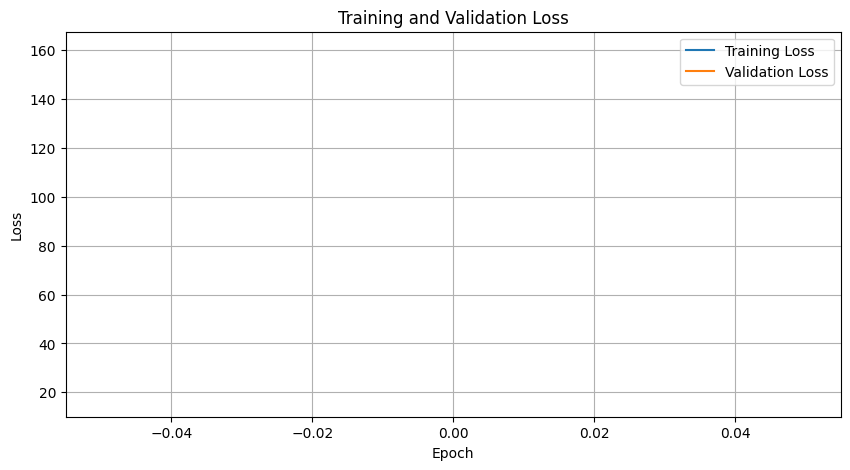

In [72]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Test phase

In [ ]:
# Testing phase
test_loss, test_acc, test_precision, test_recall, test_f1 = model.test(test_dataloader)
print(f"Testing: Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")